In [1]:
import sys
sys.path.append('/mnt/apollo/bare_soil_xuemeng/scikit-map/')
from skmap.io import RasterData
from skmap.io import process
import os

from pathlib import Path
from minio import Minio
from eumap.misc import find_files, nan_percentile, ttprint
from eumap.raster import read_rasters, save_rasters
import numpy as np
from minio.commonconfig import REPLACE, CopySource
import time as tm
import multiprocess as mp
from scipy.signal import savgol_filter, find_peaks
import math
import pandas as pd

import dask.array as da
from dask import delayed
tiles = ['006E_51N', '023E_52N'] #['004E_51N','004W_36N','005E_52N','024E_38N']#[ '006E_51N', '023E_52N', '007E_46N','016E_63N', '006W_53N', '003E_52N']
# tiles = ['016E_63N','017E_63N','006W_53N','006W_52N','003E_52N','004E_52N','003E_51N','004E_51N','005E_52N','006E_52N','005E_51N',
#          '006E_51N','023E_52N','007E_46N','008E_46N','009E_44N','010E_44N','023E_38N','024E_38N','023E_37N','004W_36N']
years = list(range(2000,2022,1))
doy = ['001','017','033','049','065','081','097','113','129','145','161','177','193','209','225','241','257','273','289','305','321','337','353']

In [2]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from pathlib import Path
            
def process_pixel(pixel, rdata):
    i, j = pixel
    ndvi_series = rdata[i, j, :]
    min_height = 0.6*10000  # NDVI higher than 0.6 could be seen as a peak
    min_prominence = 0.2*10000  # Minimum prominence is 0.2 (peak must be at least 0.2 more than neibouring troughs)
    min_distance = 6  # 6*16=96 days minimum between each peak
    
    ndvi = pd.Series(ndvi_series).interpolate()

    peaks, _ = find_peaks(ndvi, height=min_height, prominence=min_prominence, distance=min_distance)
    if peaks.size > 0:
        mean = np.mean(ndvi[peaks])
    else:
        mean = 0 

    # mean = np.mean(ndvi_series[peaks])
    return i, j, len(peaks), mean

def process_chunk(chunk, rdata):
    with ThreadPoolExecutor(max_workers=10) as executor:
        results = list(executor.map(lambda pixel: process_pixel(pixel, rdata), chunk))
    return results

def worker_phenology(tile, year):
    tile = tile.replace('_','.')
    url_prefix = 'http://192.168.1.30:8333/tmp-bare-soil/ndvi'
    local_prefix = f'/mnt/apollo/bare_soil_xuemeng/tmp_files/ndvi'
    
    files = [local_prefix+f'/{tile}/ndvi_{tile}_{year}{dd}.tif' for dd in doy]
    files = [Path(i) for i in files]
    rdata,_ = read_rasters(raster_files=files, n_jobs=30, verbose=True)
#     files = local_prefix+f'/ndvi_{tile}_' + '{dt}.tif'
    
#     group = {'ndvi': files}
#     # print(group)
#     rdata = RasterData(group, verbose=True) \
#     .timespan(f'{str(year)}001', f'{str(year)}354', date_step=16, date_unit='days', date_format='%Y%j', date_style='start_date', ignore_29feb=True) \
#     .read(n_jobs=40)
    
    # print(rdata.info)
    pixels = [(i, j) for i in range(rdata.shape[0]) for j in range(rdata.shape[1])]
    chunks = np.array_split(pixels, 50)  # Divide the pixels into 50 chunks
    
    nos = np.zeros((rdata.shape[0], rdata.shape[1]), dtype=int)
    ins = np.zeros((rdata.shape[0], rdata.shape[1]), dtype=int)
    
    ttprint(f'processing data, size {nos.shape}, year {year}')
    with ProcessPoolExecutor(max_workers=50) as executor:
        for results in executor.map(process_chunk, chunks, [rdata]*50):
            for i, j, num_peaks, peak_mean in results:
                nos[i, j] = num_peaks
                ins[i, j] = peak_mean
        
    mask = rdata > ins[:,:,np.newaxis] * 0.5
    los = np.sum(mask, axis=2) / len(mask[0,0,:])
    los[nos == 0] = 0    

    save_rasters(files[0], [f'/mnt/apollo/bare_soil_xuemeng/tmp_files/nos/nos_{tile}_{year}.tif'], nos, nodata=-99, dtype = 'int8', n_jobs=30)
    save_rasters(files[0], [f'/mnt/apollo/bare_soil_xuemeng/tmp_files/los/los_{tile}_{year}.tif'], los*100, nodata=-99, dtype = 'int8', n_jobs=30)
    
    return None


In [3]:
for tile in tiles:
    for year in years[0:1]:
        a = worker_phenology(tile,year)

[08:27:29] Reading 23 raster files using 30 workers
[08:27:41] processing data, size (4004, 4004), year 2000
[08:36:37] Reading 23 raster files using 30 workers
[08:36:48] processing data, size (4004, 4004), year 2000


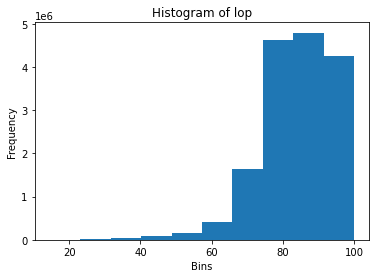

In [34]:
hist_values, hist_bins = np.histogram(pos_values)
import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(hist_bins[:-1], bins=hist_bins, weights=hist_values)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Histogram of lop')
plt.show()